<a href="https://colab.research.google.com/github/kristinacovington/Colab/blob/master/CategoricalDQNAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y xvfb ffmpeg
!pip install gym
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install pyvirtualdisplay
!pip install tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 0s (7,612 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected pa

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()


# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [27]:
env_name = "MountainCar-v0" # @param {type:"string"}
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [28]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [29]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

In [30]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

In [31]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

# Please also see the metrics module for standard implementations of different
# metrics.

-200.0

In [32]:
#@test {"skip": true}
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

In [33]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
step = 200: loss = 0.4226323962211609
step = 400: loss = 0.12444135546684265
step = 600: loss = 0.05367356538772583
step = 800: loss = 0.012177792377769947
step = 1000: loss = 0.01996704377233982
step = 1000: Average Return = -200.00
step = 1200: loss = 0.009007266722619534
step = 1400: loss = 0.00960414856672287
step = 1600: loss = 0.017231961712241173
step = 1800: loss = 0.004953763447701931
step = 2000: loss = 0.0026745395734906197
step = 2000: Average Return = -200.00
step = 2200: loss = 0.0018039221176877618
step = 2400: loss = 0.003219383303076029
step = 2600: loss = 0.001255858689546585
step = 2800: loss = 0.0006723686819896102
step = 3000: loss = 0.0011642483295872808
step = 3000: Average Return = -200.00
step = 3200: loss = 0.0004765004850924015
step = 3400: loss = 0.0019112665904685855
step = 3600: loss = 0.0014809593558311462
step = 3800: loss = 0.00031765710446052253
step = 4000: loss = 0.00016717569087632
step

(-211.0, 550.0)

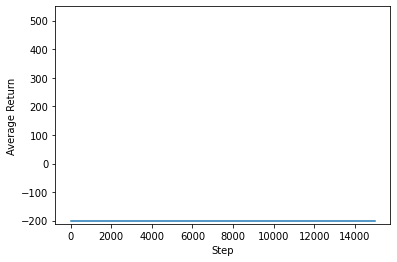

In [34]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

In [35]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [36]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)